<a href="https://colab.research.google.com/github/mongrelDS/Richters-Predicter/blob/main/Richter's_Predictor_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Driven Data Competition

This is an entry to the Richter's Predictor competition hosted by DrivenData.  ( [link here](https://www.drivendata.org/competitions/57/nepal-earthquake/)) 



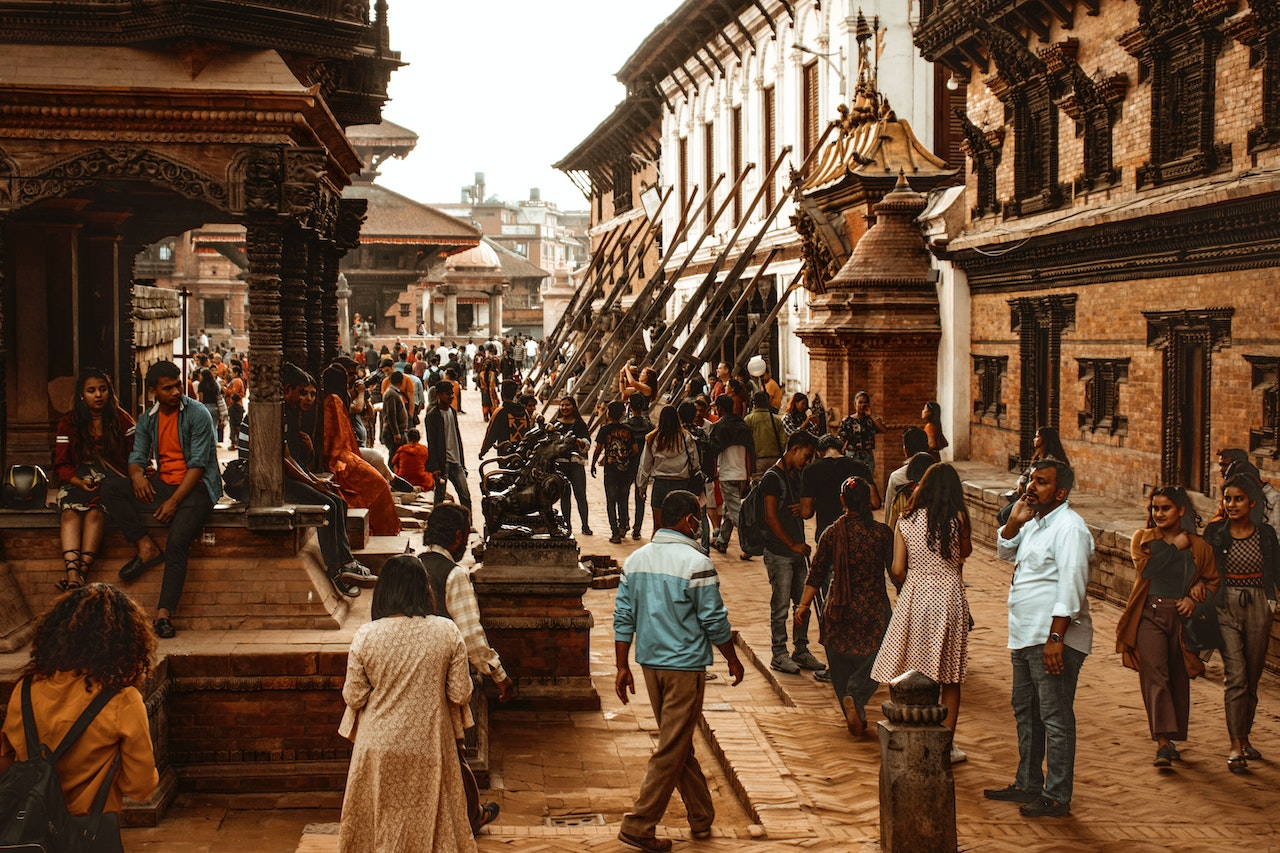


Photo by Bimal Ranabhat: [Pexels](https://www.pexels.com/photo/people-standing-near-building-2177708/)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!pip install category_encoders
from category_encoders import OneHotEncoder

In [3]:
#@title Data Import

#Submission Format	
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/submission_format.csv"
submission_format = pd.read_csv(filepath, index_col='building_id')

# Test Values	
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/test_values.csv"
df_test_values = pd.read_csv(filepath, index_col='building_id')

#Train Labels	
filepath = "https://raw.githubusercontent.com/mongrelDS/Richters-Predicter/main/train_labels.csv"
df_train_labels= pd.read_csv(filepath, index_col='building_id')

#Train Values
filepath = "https://raw.githubusercontent.com/mongrelDS/Richters-Predicter/main/train_values.csv"
df_train= pd.read_csv(filepath, index_col='building_id')

In [4]:
df_train=df_train.drop(columns= ['geo_level_1_id'])
df_test_values=df_test_values.drop(columns= ['geo_level_1_id'])

In [5]:
#@title Train Test Split
test_size = 0.1 #@param ["0.2", "0.1"] {type:"raw", allow-input: true}
random_state=42 #@param ["42", "80", "120"] {type:"raw", allow-input: true}

X_test= df_test_values
X= df_train
y = df_train_labels

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=test_size, random_state=random_state)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Confirm if train and test sets added equals X
if len(X_train) + len(X_val)==len(X): print("Data Split Successful")
else: print("Error, please retry with new params")

X shape: (260601, 36)
y shape: (260601, 1)
X_train shape: (208480, 36)
y_train shape: (208480, 1)
X_val shape: (52121, 36)
y_val shape: (52121, 1)
Data Split Successful


In [6]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print('over_sampler', X_train_over.shape)
print(y_train_over.value_counts(normalize=True))

over_sampler (356316, 36)
damage_grade
1               0.333333
2               0.333333
3               0.333333
dtype: float64


#Baseline Model

Decision Tree Classifier

In [8]:
# Fit on `X_train`, `y_train`

model_reg = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(random_state=42, max_depth= 5)
)
model_reg.fit(X_train , y_train)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    DecisionTreeClassifier(random_state=42, max_depth= 5)
)

model_over.fit(X_train_over , y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'legal_ownership_status'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [9]:
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

5


In [10]:
import sklearn
y_true=y_val

predictions= model_reg.predict(X_val)
score= sklearn.metrics.f1_score(y_true, predictions, average='micro')
print('reg score',score)

predictions= model_over.predict(X_val)
score= sklearn.metrics.f1_score(y_true, predictions, average='micro')
print('oversampled score',score)

reg score 0.5818767867078529
oversampled score 0.4418756355403772


# Catboost Boost Model

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [12]:
# wont use OHE for catboost but this cell will show me the column names to include in the 'categorical features'
encoder=OneHotEncoder(use_cat_names=True)
encoder.fit(X_train)

OneHotEncoder(cols=['land_surface_condition', 'foundation_type', 'roof_type',
                    'ground_floor_type', 'other_floor_type', 'position',
                    'plan_configuration', 'legal_ownership_status'],
              use_cat_names=True)

In [13]:
features= list(X_train.columns)
cat_features= ['geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type',
                    'ground_floor_type', 'other_floor_type', 'position',
                    'plan_configuration', 'legal_ownership_status']

In [14]:
model_cb = CatBoostClassifier(iterations=1000, random_state=42)

In [ ]:
model_cb.fit(X_train , y_train, cat_features=cat_features, plot=True, eval_set= (X_val, y_val))

In [16]:
y_true=y_val
predictions= model_cb.predict(X_val)
score= sklearn.metrics.f1_score(y_true, predictions, average='micro')
print('catboost score ',score)

catboost score  0.7468007137238348


In [31]:
#@title Submit File { form-width: "300px" }
from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

description_score=int(score*10000)
model_submit = model_cb #@param ["model_reg", "model_over", "XG"] {type:"raw", allow-input: true}

predictions= model_submit.predict(X_test)

filepath = f"/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/sub_{description_score}_{today}.csv "
my_submission = pd.DataFrame(data=predictions, columns=submission_format.columns, index=submission_format.index)
my_submission.to_csv(filepath)

print(filepath)

/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/sub_7468_2022-12-14.csv 


subm_cb_score_7468_2022-12-14.csv scored 0.7447 on drivendata